<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/rag_fusion_pipeline_PostgreSQL_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Fusion Query Pipeline

<a href="https://colab.research.google.com/github/run-llama/llama-hub/blob/main/llama_hub/llama_packs/query/rag_fusion_pipeline/rag_fusion_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to implement RAG Fusion using the LlamaIndex Query Pipeline syntax.

## Setup / Load Data

We load in the pg_essay.txt data.

In [1]:
#added by Frank Morales(FM) 11/01/2024
%pip install openai  --root-user-action=ignore
!pip install llama_index phoenix pyvis network
!pip install llama_hub
%pip install colab-env --upgrade --quiet --root-user-action=ignore
!pip install accelerate
#!pip install typing_extensions

!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet

import colab_env
import openai
import os
openai.api_key = os.getenv("OPENAI_API_KEY")

!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt' -O 'data/paul_graham/paul_graham_essay.txt' -O pg_essay.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 10.2 MB/s et

In [2]:
#ADDED By FM 11/01/2024

# install PSQL WITH DEV Libraries AND PGVECTOR
!apt install postgresql postgresql-contrib &>log
!service postgresql restart
!sudo apt install postgresql-server-dev-all

print()
# PostGRES SQL Settings
%cd /content/
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'postgres'"

print('START: PG embedding COMPILATION')
%cd /content/
!git clone https://github.com/neondatabase/pg_embedding.git
%cd /content/pg_embedding
!make
!make install # may need sudo
print('END: PG embedding COMPILATION')
print()

#!sudo -u postgres psql -c "DROP EXTENSION embedding"
!sudo -u postgres psql -c "CREATE EXTENSION embedding"
!sudo -u postgres psql -c "DROP TABLE documents"
!sudo -u postgres psql -c "CREATE TABLE documents(id integer PRIMARY KEY, embedding real[])"

 * Restarting PostgreSQL 14 database server
   ...done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  binfmt-support libffi-dev libpfm4 libz3-4 libz3-dev llvm-14 llvm-14-dev
  llvm-14-runtime llvm-14-tools postgresql-server-dev-14 python3-pygments
  python3-yaml
Suggested packages:
  llvm-14-doc python-pygments-doc ttf-bitstream-vera
The following NEW packages will be installed:
  binfmt-support libffi-dev libpfm4 libz3-4 libz3-dev llvm-14 llvm-14-dev
  llvm-14-runtime llvm-14-tools postgresql-server-dev-14
  postgresql-server-dev-all python3-pygments python3-yaml
0 upgraded, 13 newly installed, 0 to remove and 24 not upgraded.
Need to get 59.8 MB of archives.
After this operation, 361 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 python3-yaml amd64 5.4.1-1ubuntu1 [129 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 bi

In [3]:
#%pip install openai --root-user-action=ignore

openai.api_key = os.getenv("OPENAI_API_KEY")
#print(os.getenv("OPENAI_API_KEY"))

from llama_index import SimpleDirectoryReader
reader = SimpleDirectoryReader(input_files=["/content/pg_essay.txt"])
docs = reader.load_data()

In [4]:
#ADDED By FM 11/01/2024

from typing import List, Tuple
from langchain.docstore.document import Document
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import PGEmbedding

loader = TextLoader("/content/pg_essay.txt")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs0 = text_splitter.split_documents(documents)

collection_name0 = "pg_essay"
print(f'# of Document Pages {len(documents)}')
print(f'# of Document Chunks: {len(docs0)}')

# of Document Pages 1
# of Document Chunks: 100


### [Optional] Setup Tracing

We also setup tracing through Arize Phoenix to look at our outputs.

In [5]:
#import phoenix as px

#px.launch_app()
#import llama_index

#llama_index.set_global_handler("arize_phoenix")

## Setup Llama Pack

Next we download the LlamaPack. All the code is in the downloaded directory - we encourage you to take a look to see the QueryPipeline syntax!

In [6]:
# Option 1: Use `download_llama_pack`
# from llama_index.llama_pack import download_llama_pack

# RAGFusionPipelinePack = download_llama_pack(
#     "RAGFusionPipelinePack",
#     "./rag_fusion_pipeline_pack",
#     # leave the below line commented out if using the notebook on main
#     # llama_hub_url="https://raw.githubusercontent.com/run-llama/llama-hub/jerry/add_query_pipeline_pack/llama_hub"
# )

# Option 2: Import from llama_hub package
from llama_hub.llama_packs.query.rag_fusion_pipeline.base import RAGFusionPipelinePack
from llama_index.llms import OpenAI

# Mistral - MODEL

In [7]:
#ADDED By FM 11/01/2024
#%pip install colab-env --upgrade --quiet --root-user-action=ignore
#!pip install accelerate

import torch
from textwrap import fill
from IPython.display import Markdown, display

import colab_env
import os

access_token = os.getenv("HF_TOKEN")

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline
import warnings
warnings.filterwarnings('ignore')

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

#from transformers import AutoTokenizer, MistralForCausalLM

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [8]:
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.8
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
    pad_token_id=tokenizer.eos_token_id,
)

In [9]:
llm = HuggingFacePipeline(pipeline=pipeline)

In [10]:
import warnings
warnings.filterwarnings('ignore')

query = "How AWS has evolved?"
result = llm(query)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>How AWS has evolved?</b>

<p>
AWS was one of the first cloud service providers, and it has come a long way. AWS has become increasingly diverse in its offerings, from computing to storage to database services, analytics, machine learning, and more. AWS also now offers serverless architecture through Lambda, making it easier for developers to focus on writing code without worrying about infrastructure management. Additionally, AWS has introduced new services such as Elastic Kubernetes Service (EKS) and AppSync that allow for more flexibility and scalability in deploying applications. Overall, AWS has grown into a comprehensive platform that provides a wide range of tools and services for building, deploying, and managing modern applications.</p>

# EMBEDDING

In [11]:
#ADDED By FM 11/01/2024

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import PGEmbedding

# https://supabase.com/blog/fewer-dimensions-are-better-pgvector
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

collection_name='Paul Graham Essay'
connection_string = os.getenv("DATABASE_URL")

db = PGEmbedding.from_documents(
    embedding=embeddings,
    documents=docs0,
    collection_name=collection_name,
    connection_string=connection_string,
)

In [12]:
#ADDED By FM 11/01/2024
query='What did the author do growing up?'
docs_with_score: List[Tuple[Document, float]] = db.similarity_search_with_score(query)

print(query)
print()
for doc, score in docs_with_score:
    print("-" * 80)
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)

What did the author do growing up?

--------------------------------------------------------------------------------
Score:  0.5970912
What I Worked On

February 2021

Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.

The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district's 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain's lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright flu

# RAG FUSION PIPELINE

In [13]:
#modify By FM 11/01/2024

#ValueError: Unknown model 'Mistral-7B-Instruct-v0.1'.

#del pack
#Please provide a valid OpenAI model name in: gpt-4, gpt-4-32k, gpt-4-1106-preview,
#gpt-4-vision-preview, gpt-4-0613, gpt-4-32k-0613, gpt-4-0314, gpt-4-32k-0314,
#gpt-3.5-turbo, gpt-3.5-turbo-16k, gpt-3.5-turbo-1106, gpt-3.5-turbo-0613,
#gpt-3.5-turbo-16k-0613, gpt-3.5-turbo-0301, text-davinci-003, text-davinci-002,
#gpt-3.5-turbo-instruct, text-ada-001, text-babbage-001, text-curie-001,
#ada, babbage, curie, davinci, gpt-35-turbo-16k, gpt-35-turbo, gpt-35-turbo-1106,
#gpt-35-turbo-0613, gpt-35-turbo-16k-0613

#### OPENAI MODELS ########
#pack = RAGFusionPipelinePack(docs, llm=OpenAI(model="gpt-3.5-turbo"))
#pack = RAGFusionPipelinePack(docs, llm=OpenAI(model="gpt-4"))
#pack = RAGFusionPipelinePack(docs, llm=OpenAI(model="gpt-4-1106-preview"))
#pack = RAGFusionPipelinePack(docs, llm=OpenAI(model="gpt-4-vision-preview"))

### MISTRAL
pack = RAGFusionPipelinePack(docs, llm)

# Inspecting the Code

If we take a look at how it's setup (in your downloaded directory, you'll see the following code using our QueryPipeline syntax).

`retrievers` is a dictionary mapping a chunk size to retrievers (chunk sizes: 128, 256, 512, 1024).

```python
# construct query pipeline
p = QueryPipeline()
module_dict = {
    **self.retrievers,
    "input": InputComponent(),
    "summarizer": TreeSummarize(),
    # NOTE: Join args
    "join": ArgPackComponent(),
    "reranker": rerank_component,
}
p.add_modules(module_dict)
# add links from input to retriever (id'ed by chunk_size)
for chunk_size in self.chunk_sizes:
    p.add_link("input", str(chunk_size))
    p.add_link(str(chunk_size), "join", dest_key=str(chunk_size))
p.add_link("join", "reranker")
p.add_link("input", "summarizer", dest_key="query_str")
p.add_link("reranker", "summarizer", dest_key="nodes")
```


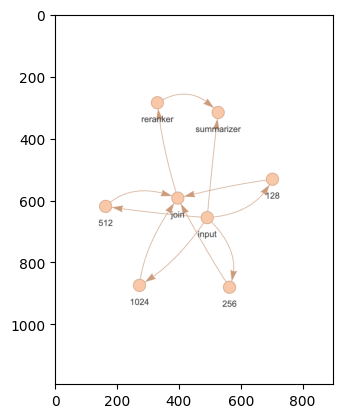

In [14]:
#!pip install llama_index phoenix pyvis network

from pyvis.network import Network
import colab_env
import matplotlib.pyplot as plt
import cv2

#['in_line','remote','local']."
net = Network(notebook=True, cdn_resources="in_line", directed=True)
#net.from_nx(pack.query_pipeline.dag)
#net.show("rag_dag.html")

ragdag="/content/gdrive/MyDrive/datasets/rag_dag-html.png"
testim = cv2.imread(ragdag)
plt.imshow(testim)
plt.show()
print()

We visualize the DAG below.

In [15]:
#modify By FM 11/01/2024

#response = pack.run(query="What did the author do growing up?")
query0="What did the author do growing up?"
query='I bought an ice cream for 6 kids. Each cone was $1.25 and I paid with a $10 bill. How many dollars did I get back? Explain first before answering.'
query1 = "Who is the President of the USA?"
query2 = "Who won the baseball World Series in 2020? and Who Lost"
query3 = 'Anything about FORTRAN'
query4 = 'Anything about LIPS'
query5 = 'Anything about Python'

response0 = pack.run(query=query0)
response1 = pack.run(query=query1)
response2 = pack.run(query=query2)
response4 = pack.run(query=query4)

print()
print(query0)
print(str(response0))
print()

print()
print(query1)
print(str(response1))
print()

print()
print(query2)
print(str(response2))
print()

print()
print(query4)
print(str(response4))
print()


What did the author do growing up?
The author worked on writing and programming during their time outside of school. They wrote short stories and tried writing programs on an IBM 1401 computer. They also mentioned their interest in philosophy and AI during college.


Who is the President of the USA?
I'm sorry, but the provided context does not contain any information about the current President of the United States.


Who won the baseball World Series in 2020? and Who Lost
I'm sorry, but the given context information does not provide any information about the baseball World Series in 2020.


Anything about LIPS
Lisp is a programming language that has been associated with AI, but it is also interesting for its own sake. It was originally intended as a formal model of computation and an alternative to the Turing machine. The core of Lisp is a language defined by writing an interpreter in itself. John McCarthy, the inventor of Lisp, initially did not realize that it could be used to prog

In [16]:
#response.source_nodes